In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Smoothing COVID data

So we'll see how a convolution works on real data.
We'll get the latest mortality figures from **GitHub**.

The [source](https://github.com/CSSEGISandData/COVID-19) is maintained by John Hopkins University.


In [2]:
! ../.g
country = 258

[master 619f7d2] web
 3 files changed, 2360 insertions(+), 57 deletions(-)
 create mode 100644 PROG/.ipynb_checkpoints/spain-checkpoint.ipynb
 create mode 100644 PROG/spain.ipynb
Counting objects: 6, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 215.20 KiB | 8.97 MiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   4b45ff4..619f7d2  master -> master


In [3]:
import requests
import pandas as pd

In [4]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)

## Visualising the data again

We'll convert to a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

- If you want to know more [read this in french](http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Data_Manipulation_Pandas.pdf).
- It's basically a table like in Excel
    - columns have names
    - rows are numbered and accessed using ```iloc```.


In [5]:
df = pd.read_csv('covid_deaths.csv')

---

## List the countries with > 10000 dead

In [6]:
 df[ df.iloc[:,-1] > 10000 ].iloc[:,[1,-1]]

,Country/Region,11/14/20
6,Argentina,35307
23,Belgium,14303
30,Brazil,165658
55,Chile,14777
89,Colombia,33829
106,Ecuador,12997
126,France,42215
130,Germany,12511
143,India,129635
144,Indonesia,15148


In [746]:
country = 228
df.iloc[country]

Province/State        NaN
Country/Region      Spain
Lat               40.4637
Long             -3.74922
1/22/20                 0
                   ...   
11/8/20             38833
11/9/20             39345
11/10/20            39345
11/11/20            40105
11/12/20            40461
Name: 228, Length: 300, dtype: object

---

It's often easier to work with a numpy array of values

In [7]:
deaths = df.iloc[country][4:].values
deaths[-50:]

array([41971, 41988, 42001, 42072, 42143, 42202, 42268, 42317, 42350,
       42369, 42445, 42515, 42592, 42679, 42760, 42825, 42875, 43018,
       43155, 43293, 43429, 43579, 43646, 43726, 43967, 44158, 44347,
       44571, 44745, 44896, 44998, 45365, 45675, 45955, 46229, 46555,
       46717, 46853, 47250, 47742, 48120, 48475, 48888, 49044, 49238,
       49770, 50365, 50928, 51304, 51766], dtype=object)

# Cumulative deaths

this looks pretty smooth

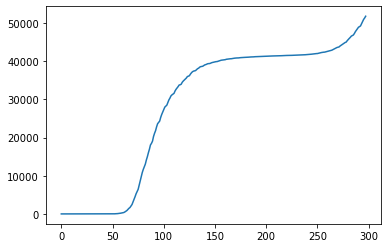

In [8]:
plt.plot(deaths);

Use ```np.diff``` to get daily death figures.

This is like differentiating the cumulative numbers.

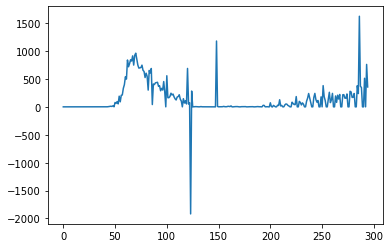

In [749]:
daily = np.diff(deaths,1)
plt.plot(daily);

Lets's look at the second wave

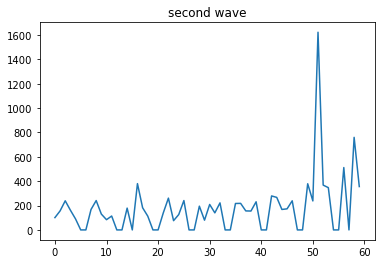

In [750]:
plt.plot(daily[-60:])
plt.title('second wave');

---

## Weekdays

The data is not too noisy compared with France.


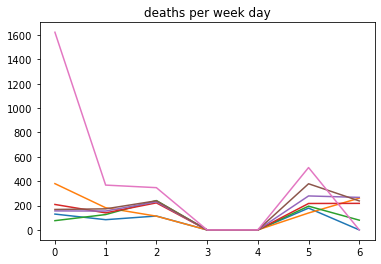

In [751]:
weeks = daily[-51:-2].reshape((-1,7))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per week day');

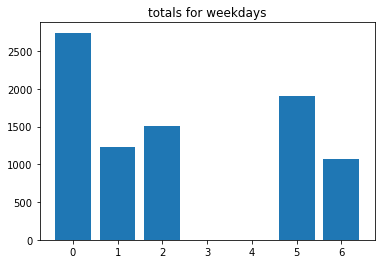

In [752]:
plt.bar(np.arange(7), np.sum(weeks, axis=0))
#plt.plot(np.sum(weeks, axis=0))
plt.title('totals for weekdays');

## Smoothing



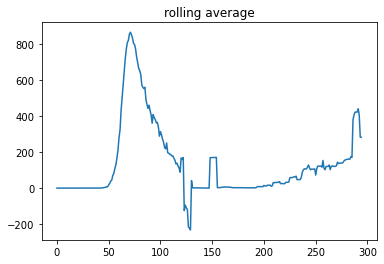

In [753]:
rolling_av = np.convolve(daily, np.ones(7)/7)[:-6]

plt.plot( rolling_av)
plt.title('rolling average');

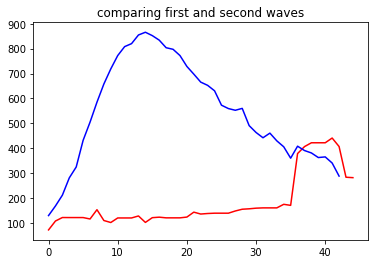

In [754]:
plt.plot(rolling_av[250:],'r')
plt.plot(rolling_av[57:100],'b');
plt.title('comparing first and second waves');

---

## Kind of dumb but..

This is a heat map of the rvalue
to see where the fit is best.

<ipython-input-772-7972a6cc4d07>:2: RuntimeWarning: divide by zero encountered in log
  YY = np.log(rolling_av.tolist())
<ipython-input-772-7972a6cc4d07>:2: RuntimeWarning: invalid value encountered in log
  YY = np.log(rolling_av.tolist())


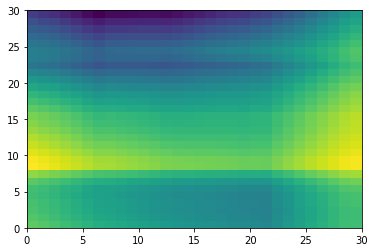

In [772]:
M = np.zeros((30,30))
YY = np.log(rolling_av.tolist())

for i, x in enumerate(range(185,215)):
    for j, y in enumerate(range(265,295)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue
        
        
plt.pcolor(M)
plt.show()

In [766]:
M[:5,18:] 

array([[0.93839147, 0.93955359],
       [0.93629141, 0.93751728],
       [0.93458052, 0.93588745],
       [0.93320941, 0.93460207],
       [0.93098776, 0.93246783]])

# Exponential  growth in deaths ?

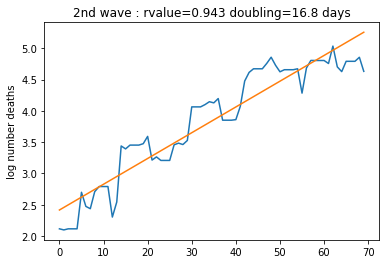

In [773]:
from scipy import stats

Y =  np.log(rolling_av[195:265].tolist())
X = np.arange(len(Y))

#plot raw data
plt.plot(X,Y);

#do regression
coeffs = stats.linregress(X,Y)
a,b = coeffs.slope, coeffs.intercept

#plot regression curve
plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
plt.title('2nd wave : rvalue={:.3f} doubling={:.1f} days'.format(coeffs.rvalue, np.log(2)/a) )
plt.ylabel('log number deaths');
    

---

## That's great!!


The exponential factor is smaller for the UK 
and the [doubling time](https://en.wikipedia.org/wiki/Doubling_time) is about 12 days !

This is still in the region of the incubation period for COVID.


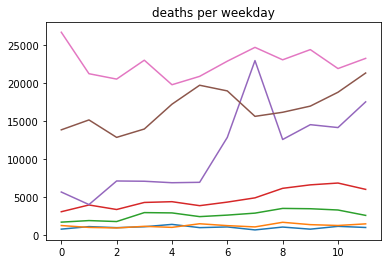

In [650]:
weeks = daily[200:-11].reshape((-1,12))
for row in weeks:
    plt.plot(row)
    
plt.title('deaths per weekday');

---

## Confirmed cases

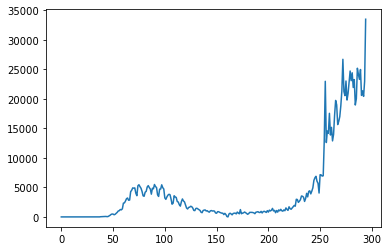

In [641]:
df = pd.read_csv('covid_confirmed.csv')

cases =  df.iloc[country][4:].values
daily = np.diff(cases, 1)
plt.plot(daily);

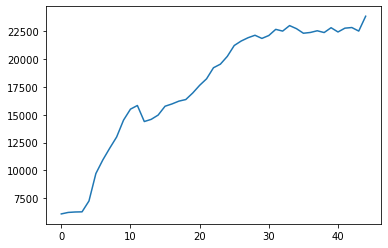

In [642]:
smoothed = np.convolve(daily, np.ones(7)/7)[:-6]
plt.plot(smoothed[250:]);

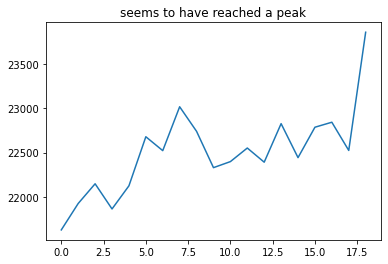

In [644]:

smoothed = np.convolve(daily, np.ones(7)/7)
plt.plot(smoothed[-25:-6]);
plt.title('seems to have reached a peak');

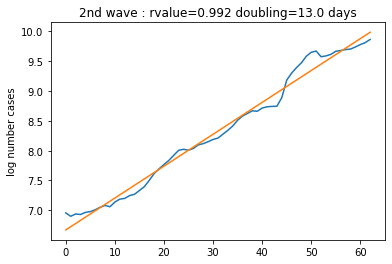

In [714]:
Y = smoothed[210:273].tolist()
X = np.arange(len(Y))

Y = np.log(Y)
plt.plot(X,Y)

coeffs = stats.linregress(X,Y)
a,b = coeffs.slope, coeffs.intercept

plt.plot( X[[0,-1]], a*X[[0,-1]] + b)
plt.title('2nd wave : rvalue={:.3} doubling={:.1f} days'.format(coeffs.rvalue, np.log(2)/a) )

plt.ylabel('log number cases');

In [606]:
np.log(2)

0.6931471805599453

# Mortality rate for the second wave

In [716]:
(deaths[-1] - deaths[210])/ (cases[-1] - cases[210])

0.00983492880485648

In [666]:
M = np.zeros((20,20))
YY = np.log(smoothed.tolist())

for i, x in enumerate(range(200,220)):
    for j, y in enumerate(range(270,290)):
        Y = YY[x:y]
        X = np.arange(y-x)
        M[i,j] = stats.linregress(X,Y).rvalue

<ipython-input-666-49efe0b4dab3>:2: RuntimeWarning: divide by zero encountered in log
  YY = np.log(smoothed.tolist())


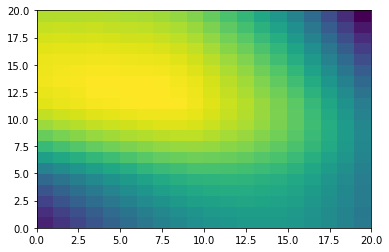

In [678]:
plt.pcolor(M)
plt.show()

In [718]:
! ../.g 

[master a8ba0be] web
 1 file changed, 74 insertions(+), 230 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 37.32 KiB | 6.22 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   21796ee..a8ba0be  master -> master


In [9]:
df = pd.read_csv('covid_deaths.csv')

In [128]:
def ref2weeks(ref):
    X = df.iloc[ref][4:].values
    X = X[len(X) % 7  + 6:]
    X = np.diff(X,1).reshape((-1,7))
    return X.sum(axis=0)

tt  = []
for ref in df[ df.iloc[:,-1] > 10000 ].index.tolist():
    X = ref2weeks(ref)
    var = (X**2).mean() - (X.mean())**2
    tt.append((np.sqrt(var)/max(X), ref , X))
        

In [25]:
tt.sort(reverse=True)


In [126]:
A, B, XS = list(zip(*tt))

ddf = pd.DataFrame({'country' : [df.iloc[:,1][k] for k in B], 'var' : A})
ddf = ddf.drop(index=5)
ddf

,country,var
0,Argentina,0.196433
1,Belgium,0.131535
2,Brazil,0.211189
3,Chile,0.204455
4,Colombia,0.066561
6,France,0.190614
7,Germany,0.197305
8,India,0.060454
9,Indonesia,0.057440
10,Iran,0.023689


In [30]:
XS[21]

array([5644, 5955, 5922, 6029, 6013, 5748, 5723], dtype=object)

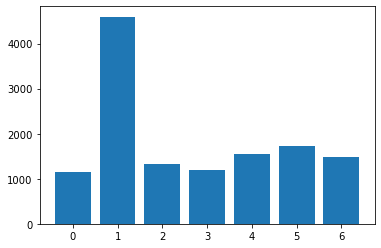

In [101]:
plt.bar(np.arange(7), XS[5]);

In [99]:
XS[5]

array([1140, 4595, 1321, 1192, 1545, 1719, 1485], dtype=object)

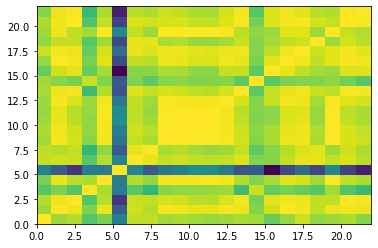

In [224]:
NXS = np.array([ x/np.linalg.norm(x) for x in XS])
cov = np.dot(NXS, NXS.T).astype(float)
plt.pcolor(cov)
plt.show()

In [151]:
vp, vecs = np.linalg.eig(cov)

In [152]:
vp.real.tolist()

[34.40728807676528,
 0.6816614478599708,
 0.4072185646403119,
 0.26274704833379603,
 0.11386952982918096,
 0.06433922772427497,
 0.0628761048471645,
 -1.8626999209061954e-15,
 -7.234852112557444e-16,
 6.480498128948825e-16,
 5.580484446107844e-16,
 5.268106293881897e-16,
 -5.162100957350016e-16,
 4.221804586543014e-16,
 -4.1816728083483936e-16,
 -4.1816728083483936e-16,
 3.633199749938691e-16,
 2.0054904403790933e-16,
 2.0054904403790933e-16,
 3.104701963993484e-16,
 2.5731064237435494e-16,
 2.5731064237435494e-16,
 -3.481739945292665e-16,
 -3.0558745771307854e-16,
 1.8644308057621114e-16,
 1.6061344335320512e-16,
 1.1325646701120478e-16,
 -2.6957348976239413e-16,
 -2.1825282757167554e-16,
 -2.1081344040466793e-16,
 -1.4178701244630848e-16,
 2.2084165889509735e-17,
 -2.58234681357231e-17,
 -2.58234681357231e-17,
 -2.1198577226895395e-17,
 -4.234572245737421e-17]

In [223]:
cov.shape, len(ref4big), len(Xx), len(Yx)

((22, 22), 36, 22, 22)

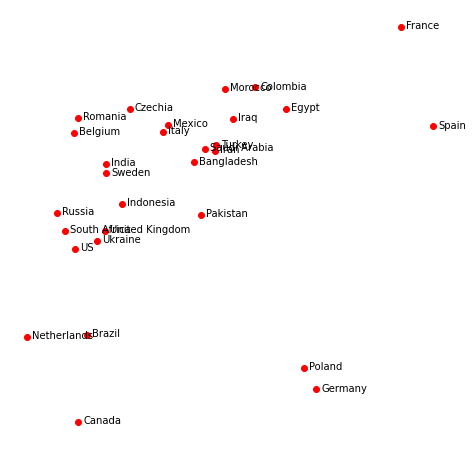

In [226]:
ref4big = df[ df.iloc[:,-1] > 4000 ].index.tolist()

WX = [ ref2weeks(ref) for ref in ref4big]
#normalise
WX = np.array([ x/np.linalg.norm(x) for x in WX]).astype(float)
#calculate covariance
cov = np.dot(WX, WX.T)

vp, vecs = np.linalg.eig(cov)

Xx = [ np.dot(-vecs[0], u).real for u in cov]
Yx = [ np.dot(vecs[1], u).real for u in cov]

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.axis('off')


labels = df.iloc[ref4big,1]
kk = 0
for label , x, y  in zip(labels,Xx, Yx): 
    if label.lower() in ['ecuador', 'china', 'bolivia']: continue
    if label.lower() in ['peru', 'chile', 'argentina', 'philippines']: continue
    
    #print(label)
    ax.plot([x], [y], 'ro');
    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(5,-2), # distance from text to points (x,y) : not same units
                 ha='left') # horizontal alignment can be left, right or center
    
    

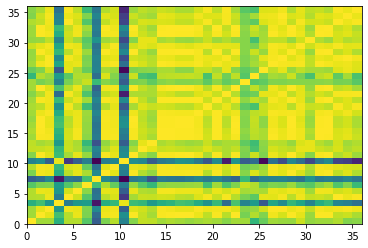

In [184]:
ref4big = df[ df.iloc[:,-1] > 4000 ].index.tolist()

WX = [ ref2weeks(ref) for ref in ref4big]
WX = np.array([ x/np.linalg.norm(x) for x in WX]).astype(float)
cov = np.dot(WX, WX.T)

plt.pcolor(cov);

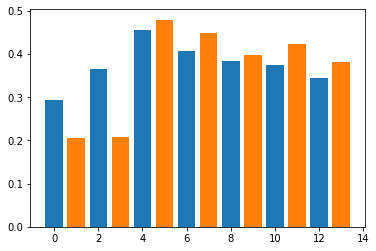

In [228]:
ii = 25

for k,ii in enumerate([9,-1]):
    plt.bar(np.arange(k,14,2), WX[ii]);
#plt.title(df.iloc[ref4big[ii], 1]);

In [206]:
pd.DataFrame( {'ref': np.arange(len(ref4big)), 'country':df.iloc[ref4big,1]} )

,ref,country
6,0,Argentina
20,1,Bangladesh
23,2,Belgium
27,3,Bolivia
30,4,Brazil
50,5,Canada
55,6,Chile
69,7,China
89,8,Colombia
98,9,Czechia
